# Initialization 

In [622]:
import cobra
from cobra.io import load_model
import cometspy as c
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from functools import partial
from collections.abc import Iterable
import re
from dataclasses import dataclass, field

E0 = cobra.io.read_sbml_model("./models/iML1515_E0.xml")
S0 = cobra.io.read_sbml_model("./models/STM_v1_0_S0.xml")
E0.id, S0.id = 'E0', 'S0'

In [3]:
# %run Div_Setup.ipynb

In [623]:
limiting_conc = 10
# E0 = cobra.io.read_sbml_model("./models/iML1515_E0.xml")
nutrient_medium = {'EX_ca2_e': 10,
 'EX_cl_e': 10,
 'EX_cobalt2_e': 10,
 'EX_cu2_e': 10,
 'EX_fe2_e': 10,
 'EX_fe3_e': 10,
 'EX_k_e': 10,
 'EX_mg2_e': 10,
 'EX_mn2_e': 10,
 'EX_mobd_e': 10,
 'EX_ni2_e': 10,
 'EX_o2_e': 10,
 'EX_pi_e': 10,
 'EX_so4_e': 10,
 'EX_zn2_e': 10,
 'EX_nh4_e': 10}
E0.medium = nutrient_medium 
S0.medium = nutrient_medium 

def change_medium(model, metabolite, value, return_medium=False): # function for setting medium metabolite value
    medium = model.medium
    if not isinstance(value, Iterable):
        metabolite, value = [metabolite], [value]
    for m, v in zip(metabolite, value):
        medium[m] = v
    model.medium = medium
    if return_medium:
        return model.medium

In [624]:
import sys
sys.path.append("..")
# sys.path.append("../../")
S2tab = pd.read_excel('S2Table.xlsx');
S2_Enzyme = list(S2tab['Enzyme'])
essential_genes = ['purU', 'pyrE', 'thrB', 'yrbG', 'folA', 'folP', 'pykF', 'rffG'] 

C:\Users\wongt\AppData\Roaming\Python\Python311\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


remove reactions involved in preexisting gene inhibition candidates

In [625]:
all_metabolites = {
    model.id: model.metabolites for model in [E0, S0]
}
all_genes = {
    model.id: 
    [gene.name for gene in model.genes if type(gene) != str]
    for model in [E0, S0]
}

all_reactions = {
    model.id: model.reactions for model in [E0, S0]
}

all_components = {'metabolites': all_metabolites,
                  'genes': all_genes, 
                  'reactions': all_reactions}
def get_component(model, query):
    ID = model.id.split('.')[0]
    if query in all_components['genes'][ID]:
        return model.genes.get_by_id(get_gene_id(model, query))
    if query in all_components['metabolites'][ID]:
        return model.metabolites.get_by_id(query)
    return model.reactions.get_by_id(query)

def get_links_component(model, query, id_only=True, is_sub_only=None):
    query = get_component(model, query)
    if type(query) in [cobra.Reaction]:
        result = query.metabolites
    else: 
        result = query.reactions 
        if type(query) is cobra.Metabolite:
            if is_sub_only is not None:
                result = [rct for rct in result if substrate_only(rct, query)==is_sub_only]
    if id_only:
        result = [ele.id for ele in result]
    return result
# get_component(E0, 'folA')

In [626]:
def get_gene_id(model, gene_name):
    for _,i in enumerate(model.genes):
        if(i.name == gene_name):
            return(i.id)

for i, Enzyme in enumerate(S2_Enzyme):
    mark_remove = False
    for _, current_gene in enumerate(essential_genes):
        for _, current_reaction in enumerate(E0.genes.get_by_id(get_gene_id(E0,current_gene)).reactions):           
            if (Enzyme==current_reaction.id):
                mark_remove = True
                print(current_reaction.id)
    if (mark_remove == True):
        S2_Enzyme.remove(Enzyme)                 

DHPS2
DHFR
PYK


# E0 limiting lactose

In [627]:
def retrive_model_in_medium(key, media):
    model = E0 if 'E0' in key else S0
    model.medium = media[key]
    *ID, _ = key.split('_')
    model.id = '.'.join(ID)
    return model 

media = dict()
c_limiting_conc = 1
met_limiting_conc = 0.08

# more met_limiting
with E0, S0:
#     media['E0_unlimited'] = lactose_met_medium
    with E0:
        media['E0.lcts_limited'] = change_medium(E0, ['EX_lcts_e', 'EX_met__L_e'], [c_limiting_conc, 10], True)
    media['E0.Met_limited'] = change_medium(E0, ['EX_lcts_e', 'EX_met__L_e'], [10, met_limiting_conc], True)
    with S0:
        media['S0.ac_limited'] = change_medium(S0, 'EX_ac_e', c_limiting_conc*6, True)
    media['S0.gal_limited'] = change_medium(S0, 'EX_gal_e', c_limiting_conc*2, True)
model_ids = [ele.split('_')[0] for ele in media.keys()]
list_target_obj_val = {media_key: retrive_model_in_medium(media_key, media).slim_optimize()/2
                        for media_key in media.keys()}

# KO essentiality

In [628]:
with open("./Data/potential_genes", "r") as fp:
    potential_genes = json.load(fp)
first_n_genes = len(potential_genes)
def get_essentiality_df(first_n_genes = len(potential_genes)):
    biomass_dict = dict()

    for medium_key in media.keys():
        model = retrive_model_in_medium(medium_key)
        biomass_key = model.id
        biomass_dict[biomass_key] = {'Normal': model.slim_optimize()}
        for SG in potential_genes[:first_n_genes]:
            with model:    
                for rct in get_links_component(model, SG, id_only=False):
                    rct.knock_out()
                biomass_dict[biomass_key].update({SG: model.slim_optimize()})
    essentiality_df = pd.DataFrame.from_dict(biomass_dict)
#     essentiality_df = essentiality_df.apply(classify_essentiality)
#     return biomass_dict
    return essentiality_df
# fill_biomass_dict(model)

def classify_essentiality(s: pd.Series):
#     return s.index
#     intervals = [-1, s.Normal/100, s.Normal*.95 , s.Normal*1.1]
    s=1-s/s.Normal
    intervals = [-1, 1/100, 1*.5 ,1*.98, 1*1.1]
#     intervals = [1.1, 1*.98, 1*.5 ,1/100, 1]
#     intervals = [-1, s.Normal/100, s.Normal*.5 ,s.Normal*.98, s.Normal*1.1]
    return pd.cut(s.rename(f'Essentiality_{s.name}'),
#                   bins=intervals, labels=['Essential', 'Phenotype','(Small)Trait', 'Non_essential'], )
                  bins=intervals, labels=['Non_essential','(Small)Trait', 'Phenotype', 'Essential' ], )


In [629]:
# essentiality_df = get_essentiality_df()
essentiality_df.apply(classify_essentiality)['E0.lcts']

Normal    Non_essential
glyA       (Small)Trait
gltA          Essential
tktA          Essential
dapF          Essential
dapB          Essential
acnB          Essential
pgk        (Small)Trait
talB      Non_essential
mrcA          Essential
pyrE          Essential
dapD          Essential
pfkA      Non_essential
gdhA       (Small)Trait
folA          Essential
mrdA          Essential
thrB          Essential
dapA          Essential
serC          Essential
argD          Essential
thrC          Essential
aceF       (Small)Trait
pykF      Non_essential
dadX          Essential
folC          Essential
pyrD      Non_essential
trpA          Essential
serB       (Small)Trait
fbp       Non_essential
eno        (Small)Trait
pgi        (Small)Trait
pheA          Essential
gcvH      Non_essential
gnd       Non_essential
murA          Essential
aroA          Essential
guaB      Non_essential
glnA          Essential
yrbG          Essential
folP          Essential
purU      Non_essential
serA       (Smal

# Find gene decoding

In [630]:
alpha,obj_val = 1,0 
def separate_reaction(model, reaction_id, forward_terminal_change = True):
    """
    decompose reversible reaction into forward and backward
    forward_terminal_change : classification of whether the forward reaction aligns with sign of FVA  
    if direction aligns, terminal metabolite is to be scaled -> original reaction
    if direction is opposite, quantity of both substrate and product in reaction is kept intact -> reaction_v1
    """
    
    (lb, ub) = model.reactions.get_by_id(reaction_id).bounds 
    rct_ids = [reaction_id] #? 
    if(lb < 0 and ub !=0): # only perform if reaction is bidirectional
        intact_reaction = model.reactions.get_by_id(reaction_id).copy() # copy of target reaction

        if (forward_terminal_change ==True): # forward reaction matches sign of FVA bound 
            model.reactions.get_by_id(reaction_id).bounds = (0,ub) # forward only for the orginal reaction
            intact_reaction.bounds = (lb,0) # backward only for reaction_v1
        else: # forward reaction is opposite of sign of FVA bound 
            model.reactions.get_by_id(reaction_id).bounds = (lb,0) 
            intact_reaction.bounds = (0,ub)

        intact_reaction.id = f'{reaction_id}_v1' # redefine id for copy of reaction
        model.add_reactions([intact_reaction]) # add to model
        rct_ids.append(intact_reaction.id) # list of id for reaction and reaction_v1 
#         print(rct_ids)
    return(rct_ids)

def convert_arg_to_list(arg):
    if type(arg) is not list and type(arg) is not tuple:
        arg = [arg]
    return(arg)

def get_summary_df(model = E0, alpha = alpha, obj_val = obj_val, rct_ids = 'DHFR', sol_sol = None): 
#     summarize solutions from optimization and alpha used  
# expect direction opposite with zero flux, to be consistent with FVA bound 
    if type(alpha) != int and type(alpha) != float:
        alpha = str(alpha)
    if sol_sol is not None:
        rct_dir, rct_rev, flux_dir, flux_rev = list(), list(), list(), list()
        for current_rct_id in rct_ids:
            append_str = str(model.reactions.get_by_id(current_rct_id))
            if ('_v1' not in current_rct_id): # direction align with FVA
                rct_dir.extend([append_str])
                try:
                    flux_dir.extend([round(model.reactions.get_by_id(current_rct_id).flux,5)])
                except: 
                    flux_dir.extend([sol_sol[current_rct_id]])
            else: # direction opposite
                rct_rev.extend([append_str])        
                try:
                    flux_rev.extend([round(model.reactions.get_by_id(current_rct_id).flux,5)])
                except:
                    flux_rev.extend([sol_sol[current_rct_id]])
    #     rct_rev = fix_string(rct_rev)
    #     rct_dir = fix_string(rct_dir)
        net_flux = sum(abs(element) for element in set(flux_dir) | set(flux_rev))
        net_flux_I = 'Zero Flux' if net_flux ==0 else 'Net Flux'

    #     if type(alpha) is list or type(alpha) is tuple:

        summary_df = pd.DataFrame({f'div_opt_alpha': alpha,
                                   f'div_opt_obj_val': obj_val,
                                   f'FVAdir_Reactions_id': ', '.join(rct_ids),
                                   f'FVAdir_Reactions_involved': ' '.join(rct_dir),                                    
                                   f'FVAdir_Flux_values':[flux_dir],
                                   f'FVAopposite_Reactions_involved': ', '.join(rct_rev),     
                                   f'FVAopposite_Flux_values':[flux_rev],
                                   f'Net_Flux_Boolean':[net_flux_I],
                                   f'Net_Flux':[net_flux]}
                                 )
#     else:
#         summary_df = pd.DataFrame([{'div_opt_obj_val': obj_val}])        
    return(summary_df)

# def swap_gene_pair_order(alphas, genes,exception=500): # larger alpha come first 
#     if len(alphas)>1:  
#         cond = ((alphas[1]>alphas[0] or alphas[0] == exception) and # keep larger alpha in front, except for nonessential genes
#             alphas[1] != exception)                           
#         alphas, genes= list(reversed(alphas)), list(reversed(genes))
#     return(alphas, genes)
def scale_reaction(model, reaction_id, alpha, direction='forward'):
    if direction == 'forward':
        model.reactions.get_by_id(reaction_id).lower_bound = 0
        dict_product = dict((k, v) for k, v in model.reactions.get_by_id(reaction_id).metabolites.items() if v >= 0)    # obetain 'end product'
    else:  # reverse reaction
        model.reactions.get_by_id(reaction_id).upper_bound = 0
        dict_product = dict((k, v) for k, v in model.reactions.get_by_id(reaction_id).metabolites.items() if v <= 0)
    
    for product, unit in dict_product.items():  # scale corresponding metabolite units involved in the reaction
        model.reactions.get_by_id(reaction_id).add_metabolites({product: -unit*(1-1/alpha)}) # only change unit of unidirection metabolite
    return None

def separate_reaction(model, reaction_id, alpha):
    """
    decompose reversible reaction into forward and backward
    scale each end product by 1/alpha
    """
    (lb, ub) = model.reactions.get_by_id(reaction_id).bounds 
    rct_ids = [reaction_id] #? 
    if(lb < 0 and ub !=0): # only perform if reaction is bidirectional
        rev_reaction = model.reactions.get_by_id(reaction_id).copy() # copy of target reaction 
        rev_reaction.id = f'{reaction_id}_v1' # redefine id for copy of reaction
        model.add_reactions([rev_reaction]) # add to model
    
        scale_reaction(model, rev_reaction.id, alpha, direction='backward')      
        
        rct_ids.append(rev_reaction.id) # list of id for reaction and reaction_v1 
    scale_reaction(model, reaction_id, alpha, direction='forward')
    return(rct_ids)

def alter_Sij(model, alphas = 1, genes = 'folA'): 
    # get objective value for corresponding alpha
    alphas= convert_arg_to_list(alphas[0]) if isinstance(alphas,list) and len(alphas)==1 else convert_arg_to_list(alphas)  # unlist one layer from zip comprehension 
    genes =  convert_arg_to_list(genes)
#     print(model, genes,alphas)
    
    genes_dict = {gene: alpha for gene, alpha in zip(genes, alphas)}
    genes_sorted = sorted(genes_dict.items(), key=lambda x:x[1], reverse=True) #sort by magnitude of alpha
    rct_ids = list() # store list of id of reaction and reaction_v1 that regulated by the same gene 
    for current_gene, alpha in genes_sorted:
        current_gene = current_gene.split('_')[0] # for step_alpha
        for rct in model.genes.get_by_id(get_gene_id(model, current_gene)).reactions: 
            if (rct.id not in rct_ids):
#                 print(current_gene, alpha)
                rct_ids.extend(separate_reaction(model, rct.id, alpha))# copy of reaction, forward_terminal_change = True
    return(rct_ids)

def Sij_obj(model = E0, alphas = 1, genes = 'folA', slim_opt = False): 
    with model:
        rct_ids = alter_Sij(model, alphas, genes)
        if (slim_opt == False):
            sol_sol = model.optimize()    
            obj_val = sol_sol.objective_value     
            summary_df = get_summary_df(model, alphas, obj_val, rct_ids, sol_sol.fluxes)  
            return(alpha, obj_val, summary_df)            
        else: 
#             return(pd.DataFrame([{f'div_opt_obj_val': model.slim_optimize()}]))
            return(model.slim_optimize())    

# convert find_alpha parameter into dataclass

In [708]:
@dataclass()
class AlphaFinder:    
    model: cobra.Model | str
    search_alpha : float
    current_gene : str
    target_obj_val : float = 0.5
    opt_df : pd.DataFrame | None = None
    alpha_lb : float = 1+1e-7
    alpha_ub : float = 1e5
    exp_leap : int = 2
    precision : int = 3
    found_alpha : bool = None
    is_new_ub : bool = None   
    summary_df : pd.DataFrame = field(default_factory=pd.DataFrame)
    
    @staticmethod
    def get_next_alpha(search_alpha, alpha_lb, alpha_ub, is_new_ub, exp_leap):
#         print(search_alpha)
        if (is_new_ub == False):  # raise lb, search higher alpha
            alpha_lb = search_alpha
            if(search_alpha*exp_leap <alpha_ub): # exponential search(large step)
                if (search_alpha*exp_leap <alpha_ub and is_new_ub == False): 
                    search_alpha *= exp_leap
            else: # binary search (small step), adjust towards alpha_ub            
                search_alpha = (search_alpha+alpha_ub)/2        
        else: # search alpha not accepted, lower ub, lower search_alpha
            # start binary search, in (alpha_lb, search_alpha)
            alpha_ub = search_alpha
            search_alpha = max((search_alpha+alpha_lb)/2      
                               ,1+1e-5) # cater for small & large search  ? why 1e-5
        return search_alpha, alpha_lb, alpha_ub

    @staticmethod
    def is_found(search_alpha, alpha_lb, alpha_ub, precision):
        return (round(search_alpha,precision)==round(alpha_ub,precision) or
                                 round(search_alpha,precision)==round(alpha_lb,precision) or
                                (search_alpha>9e4))
        
    def evaluate_alpha(self):
#         print(self.search_alpha)
        _, obj_val, summary_df = Sij_obj(self.model, self.search_alpha, self.current_gene)

        if(self.opt_df is None and summary_df['Net_Flux'][0]<1e-8): # reinitialize if the first alpha to search gives zero flux
            self.search_alpha = 1+2e-3
            _, obj_val, summary_df = Sij_obj(self.model, self.search_alpha, self.current_gene)

        self.is_new_ub = (summary_df['Net_Flux'][0]<1e-8 or summary_df['Net_Flux'][0]>100 or 
                          obj_val<self.target_obj_val*.85 or obj_val>1) # overinhibition, search alpha too high 
        self.found_alpha = self.is_found(self.search_alpha, self.alpha_lb, self.alpha_ub, self.precision)
        
        # update optimal df
        net_flux_req = (summary_df['Net_Flux'][0]>0) and (self.is_new_ub == False)
        obj_val = summary_df['div_opt_obj_val'][0]
        obj_req = (obj_val > self.target_obj_val*0.85) and (obj_val < self.target_obj_val*1.1) 
        if (net_flux_req and obj_req) or (self.opt_df is None): # store only qualified alpha
            self.opt_df = summary_df
        self.opt_df = summary_df
        
#         return None
        print(self.search_alpha, self.found_alpha, self.is_new_ub, self.alpha_lb, self.alpha_ub)
#         return(search_alpha, found_alpha, is_new_ub, opt_df)

    def modify_opt_df(self):
        opt_df = self.opt_df
        print(self.current_gene, opt_df['div_opt_alpha'][0], opt_df[f'div_opt_obj_val'][0])
    #     opt_df['div_opt_alpha'] = np.floor(opt_df['div_opt_alpha'][0]*10**(precision))/10**(precision)
        opt_df.insert(loc=2, column='Percent_target_biomass', value=opt_df['div_opt_obj_val']/self.target_obj_val)
    #     opt_df.insert(loc=3, column='Essentiality', value=)
        opt_df.columns = [f'{self.model.id}_'+element for element in opt_df.columns]
        self.opt_df = opt_df
        return (opt_df[f'{self.model.id}_div_opt_alpha'],opt_df[f'{self.model.id}_div_opt_obj_val'],opt_df) # alpha_feasible, and upper bound of alpha
    
    def find_feasible_alpha(self): 
        self.evaluate_alpha() # initialize None variables
        while not self.found_alpha: 
            self.search_alpha, self.alpha_lb, self.alpha_ub = self.get_next_alpha(
                self.search_alpha, self.alpha_lb, self.alpha_ub,  self.is_new_ub, self.exp_leap)
            self.evaluate_alpha()
        
        return self.modify_opt_df()

In [680]:
def get_div_obj_df(model_id, list_target_obj_val, 
#                    first_n_gene=3, alpha_df = None): 
                   first_n_gene=None, alpha_df = None, precision=6, potential_genes=potential_genes, media=media): 

    # generate full biomass dataframe for a single species
    # given alpha or automatic search for optimal with the given objective value
    if not first_n_gene: first_n_gene = len(potential_genes)

    if '_limited' in model_id:
        medium_key = model_id
        model_id = model_id.replace('_limited','')
    else:
        medium_key = model_id+'_limited'

    print(medium_key)
    model = retrive_model_in_medium(medium_key, media) if isinstance(model_id,str) else model_id
    target_obj_val = list_target_obj_val[medium_key]
    with model:
        obj_div_df = pd.DataFrame()
        query_gene_list = list(potential_genes)[:first_n_gene] if isinstance(first_n_gene, (int, float)) else list(potential_genes)[first_n_gene[0]:first_n_gene[1]]
        for i, current_gene in enumerate(query_gene_list): # iter gene 
#         for i, current_gene in enumerate(obj_flux_df.index[1:][:1]): # iter gene 
            print(current_gene,'in cal')

            if alpha_df is None:
                if(current_gene=='yrbG'):
                    alpha,obj_value,temp_df = Sij_obj(model, alphas = 1.00001,
                                                      genes= 'yrbG')
                    temp_df.columns = [f'{model_id}_'+element for element in temp_df.columns]
                else:
                    search_alpha = 1.02
                    AF = AlphaFinder(model, search_alpha, current_gene, target_obj_val, precision=precision)
                    alpha,obj_value,temp_df = AF.find_feasible_alpha()
            else:
                alpha = alpha_df.loc[current_gene,f'{model_id}_div_opt_alpha'] # get alpha for corresponding gene from alpha_df
                alpha,obj_value,temp_df = Sij_obj(model, alpha, #.pop?
                                              genes = current_gene, model_id = model_id)

            temp_df['Gene_inhibition'] = current_gene    
    #         print(alpha, current_gene, )
            obj_div_df = pd.concat([obj_div_df, temp_df.set_index('Gene_inhibition')],axis=0)
#         add_prefix_div_df(obj_div_df, f'{model_id}') 
#         print(obj_div_df.index)
    return(obj_div_df)

# alpha_obj

In [709]:
media_key= 'E0.lcts'
E0_df = get_div_obj_df(media_key, list_target_obj_val=list_target_obj_val, 
                           alpha_df=None, precision=4, first_n_gene=[12,13])

E0.lcts_limited
gdhA in cal
1.002 False False 1.0000001 100000.0
2.004 False True 1.002 100000.0
1.5030000000000001 False True 1.002 2.004
1.2525 False True 1.002 1.5030000000000001
1.12725 False True 1.002 1.2525
1.064625 False True 1.002 1.12725
1.0333125 False True 1.002 1.064625
1.01765625 False True 1.002 1.0333125
1.0098281249999999 False True 1.002 1.01765625
1.0059140625 False False 1.002 1.0098281249999999
1.00787109375 False False 1.0059140625 1.0098281249999999
1.008849609375 False True 1.00787109375 1.0098281249999999
1.0083603515625 False False 1.00787109375 1.008849609375
1.0086049804687498 False False 1.0083603515625 1.008849609375
1.0087272949218749 False True 1.0086049804687498 1.008849609375
1.0086661376953123 False False 1.0086049804687498 1.0087272949218749
1.0086967163085936 False False 1.0086661376953123 1.0087272949218749
1.008712005615234 False False 1.0086967163085936 1.0087272949218749
1.0087196502685545 False False 1.008712005615234 1.0087272949218749
1.00872

In [143]:
def iter_species(models,f,*args,**kwargs): # model as media_key or cobra.Model
    r_object = list()
    # Multiprocessing_pool
    # TODO: should use partial of f?
    if type(models) is not zip: # zip positional arguments for different iter, kwargs will be fixed
        for model in models:
            r_object.append(f(model,*args,**kwargs))
    else:
        for model, *extra_objects in models: 
            r_object.append(f(model,extra_objects,*args,**kwargs))
    return(r_object)

In [483]:
media.keys(), list_target_obj_val.keys()

(dict_keys(['E0.lcts_limited', 'E0.Met_limited', 'S0.ac_limited', 'S0.gal_limited']),
 dict_keys(['E0.lcts_limited', 'E0.Met_limited', 'S0.ac_limited', 'S0.gal_limited']))

In [486]:
def subset_cols(df, string_list=['div_opt_alpha', 'Percent_target_biomass']):
    cols = df.columns
    regexp = re.compile('|'.join(convert_arg_to_list(string_list)))
    return [col for col in cols if bool(regexp.search(col))]

def get_full_alpha_obj_df(list_target_obj_val, alpha_obj_df_list=None, precision=4, first_n_gene=None, potential_genes=potential_genes, media=media):
    if not alpha_obj_df_list:
        model_ids = [ele.split('_')[0] for ele in list_target_obj_val.keys()]
        alpha_obj_df_list = iter_species(model_ids, get_div_obj_df,list_target_obj_val=list_target_obj_val, 
                               alpha_df=None, precision=precision, first_n_gene=first_n_gene, potential_genes=potential_genes, media=media) # output likely unrelated to precisoon
    return pd.concat(alpha_obj_df_list, axis=1)

# def get_alpha_obj_df(full_df):
#     return full_df[subset_cols(full_df, 'div_opt_alpha')]

In [493]:
full_alpha_obj_df.columns

Index(['E0.lcts_div_opt_alpha', 'E0.lcts_div_opt_obj_val',
       'E0.lcts_Percent_target_biomass', 'E0.lcts_FVAdir_Reactions_id',
       'E0.lcts_FVAdir_Reactions_involved', 'E0.lcts_FVAdir_Flux_values',
       'E0.lcts_FVAopposite_Reactions_involved',
       'E0.lcts_FVAopposite_Flux_values', 'E0.lcts_Net_Flux_Boolean',
       'E0.lcts_Net_Flux', 'E0.Met_div_opt_alpha', 'E0.Met_div_opt_obj_val',
       'E0.Met_Percent_target_biomass', 'E0.Met_FVAdir_Reactions_id',
       'E0.Met_FVAdir_Reactions_involved', 'E0.Met_FVAdir_Flux_values',
       'E0.Met_FVAopposite_Reactions_involved',
       'E0.Met_FVAopposite_Flux_values', 'E0.Met_Net_Flux_Boolean',
       'E0.Met_Net_Flux', 'S0.ac_div_opt_alpha', 'S0.ac_div_opt_obj_val',
       'S0.ac_Percent_target_biomass', 'S0.ac_FVAdir_Reactions_id',
       'S0.ac_FVAdir_Reactions_involved', 'S0.ac_FVAdir_Flux_values',
       'S0.ac_FVAopposite_Reactions_involved', 'S0.ac_FVAopposite_Flux_values',
       'S0.ac_Net_Flux_Boolean', 'S0.ac_Net_Flux'

In [494]:
def get_alpha_obj_df(full_alpha_obj_df, add_ess=True):
    def add_essentiality(alpha_obj_df):
        essentiality = list()
#         def classify_response(s):
#             intervals = [-1, .5, 1.8, 1e2]
#             return pd.cut(s,
#                 bins=intervals, labels=['Step Inhibition', 'Essential or Phenotype', 'Non_essential'])

        for model_id in model_ids:
            temp_df = classify_response(alpha_obj_df[f'{model_id}_Percent_target_biomass'])
            temp_df.name = f'{model_id}_response'
            essentiality.append(temp_df)
        return pd.concat(itertools.chain(*[[alpha_obj_df], essentiality]),axis=1)
    alpha_obj_df = full_alpha_obj_df.filter(regex='div_opt_alpha|Percent_target_biomass')
    return add_essentiality(alpha_obj_df) if add_ess else alpha_obj_df

def get_switch_alpha_check():
    use_alpha, derive_bm = 'E0.Met_div_opt_alpha', 'E0.lcts_limited'
    # col_use_alpha_bm = use_alpha.replace('div_opt_alpha', 'div_opt_obj_val')
    col_derive_ogbm = derive_bm.replace('limited', 'Percent_target_biomass')
    model = retrive_model_in_medium(derive_bm)

    cross_dict = dict()
    for current_gene, row in full_alpha_obj_df.iterrows():
        cross_dict[current_gene] = [(Sij_obj(model, row[use_alpha], current_gene, True)
                                 /list_target_obj_val[derive_bm]), # bm for derived
                                 full_alpha_obj_df.loc[current_gene, col_derive_ogbm]] # bm for original@derived
    result_df = (full_alpha_obj_df[['E0.lcts_div_opt_alpha','E0.Met_div_opt_alpha']].
                 join(pd.DataFrame.from_dict(cross_dict, columns=['Derived', 'OG'],orient='index')))
    return result_df

def classify_response(s):
    intervals = [1e2,  1.8,-1 ]
    return pd.cut(1-s,
#         bins=1-intervals, labels=['Step Inhibition', 'Essential or Phenotype', 'Non_essential'])
        bins=[1-ele for ele in intervals], labels=[ 'Non_essential', 'Essential or Phenotype'])


In [299]:
# full_alpha_obj_df = get_full_alpha_obj_df(list_target_obj_val)
alpha_obj_df = get_alpha_obj_df(full_alpha_obj_df)

In [532]:
essential_genes = alpha_obj_df.query('`E0.lcts_response` !="Non_essential"').index

In [201]:
switch_alpha_check = get_switch_alpha_check()

,E0.lcts_div_opt_alpha,E0.Met_div_opt_alpha,Derived,OG
Gene_inhibition,,,,
glyA,1.027969,99999.494121,1.974326,1.976562
gltA,2.550000,4.590000,0.650087,1.036237
tktA,17.818125,50.721094,0.524020,1.023973
dapF,23.746875,38.672344,0.765743,1.013559
dapB,7.267500,9.626250,0.793419,0.950183
acnB,3.315000,7.267500,0.402249,1.105462
pgk,1.055859,1.171406,1.710491,1.712613
talB,1.027969,1.020000,1.999106,1.998751
mrcA,4.590000,9.626250,0.352547,1.019591


In [169]:
alpha_obj_df.to_csv('./Data/alpha_obj.csv')
with pd.ExcelWriter('./Data/analysis_alpha_table.xlsx') as writer:  
    alpha_obj_df.to_excel(writer, sheet_name='alpha_obj')
    full_alpha_obj_df.to_excel(writer, sheet_name='full_alpha_obj')
    switch_alpha_check.to_excel(writer, sheet_name='switch_alpha_check')
# a_t = pd.read_csv('alpha_table.csv').set_index('Gene_inhibition')

# Comparison for various limiting conc
No alpha change varying carbon concentration

Alpha vary in magnitude subject to limitation of concentation Met

10lcts 0.08 Met 

In [ ]:
essential_genes = alpha_obj_df.query('`E0.lcts_response` !="Non_essential"').index

In [436]:
limiting_conc = .02
limiting_component='Met'
first_n_gene=2
media = dict()
if not first_n_gene: first_n_gene = len(essential_genes)
# more met_limiting
with E0, S0:

    if limiting_component == 'lcts':
        media['E0.lcts_limited'] = change_medium(E0, ['EX_lcts_e', 'EX_met__L_e'], [limiting_conc, 10], True)
    elif limiting_component == 'Met':
        media['E0.Met_limited'] = change_medium(E0, ['EX_lcts_e', 'EX_met__L_e'], [10, limiting_conc], True)
    elif limiting_component == 'ac':
        media['S0.ac_limited'] = change_medium(S0, 'EX_ac_e', limiting_conc*6, True)
    elif limiting_component == 'gal':
        media['S0.gal_limited'] = change_medium(S0, 'EX_gal_e', limiting_conc*2, True)
model_ids = [ele.split('_')[0] for ele in media.keys()]
list_target_obj_val = {media_key: retrive_model_in_medium(media_key, media).slim_optimize()/2
                        for media_key in media.keys()}

In [435]:
# list_target_obj_val
met_min= get_full_alpha_obj_df(list_target_obj_val,precision=2, first_n_gene=first_n_genes,potential_genes=essential_genes)

E0.Met_limited
purU in cal
1.02
2.04
4.08
8.16
16.32
32.64
65.28
130.56
261.12
522.24
1044.48
2088.96
4177.92
8355.84
16711.68
33423.36
66846.72
83423.36
91711.68
purU 91711.68 0.12994522808636166
pyrE in cal
1.02
2.04
4.08
8.16
16.32
32.64
65.28
130.56
261.12
131.07
196.095
163.58249999999998
147.32625
155.45437499999997
151.3903125
153.42234374999998
154.43835937499998
154.94636718749996
155.20037109374996
155.07336914062495
155.13687011718747
155.1051196289062
155.12099487304684
155.1130572509765
pyrE 155.1130572509765 0.06497553021012009
thrB in cal
1.02
2.04
4.08
8.16
16.32
32.64
65.28
33.15
49.215
41.182500000000005
45.198750000000004
43.190625000000004
44.1946875
44.69671875
44.947734375
44.822226562500006
44.88498046875
44.853603515625004
44.8692919921875
44.87713623046875
thrB 44.87713623046875 0.06496972610472529
yrbG in cal
folA in cal
1.02
2.04
4.08
8.16
16.32
32.64
65.28
130.56
261.12
522.24
261.63
391.935
326.7825
359.35875
375.646875
383.79093750000004
379.71890625000003

In [495]:
def limiting_conc_compare(limiting_component, limiting_conc, join=None, first_n_gene=None):
    media = dict()
    if not first_n_gene: first_n_gene = len(essential_genes)
    # more met_limiting
    with E0, S0:
        
        if limiting_component == 'lcts':
            media['E0.lcts_limited'] = change_medium(E0, ['EX_lcts_e', 'EX_met__L_e'], [limiting_conc, 10], True)
        elif limiting_component == 'Met':
            media['E0.Met_limited'] = change_medium(E0, ['EX_lcts_e', 'EX_met__L_e'], [10, limiting_conc], True)
        elif limiting_component == 'ac':
            media['S0.ac_limited'] = change_medium(S0, 'EX_ac_e', limiting_conc*6, True)
        elif limiting_component == 'gal':
            media['S0.gal_limited'] = change_medium(S0, 'EX_gal_e', limiting_conc*2, True)
    print(media.values())
    model_ids = [ele.split('_')[0] for ele in media.keys()]
    list_target_obj_val = {media_key: retrive_model_in_medium(media_key, media).slim_optimize()/2
                            for media_key in media.keys()}
    print(list_target_obj_val, model_ids)
    met_min= get_full_alpha_obj_df(list_target_obj_val,precision=2, first_n_gene=first_n_genes,potential_genes=essential_genes)
    alpha_met_min = get_alpha_obj_df(met_min, add_ess=False)
    
    og_col = [col for col in alpha_met_min.columns if 'opt_alpha' in col]
# alpha_met_min.join(alpha_obj_df[og_col], rsuffix='_8')
    if not join: 
        return alpha_met_min
    return alpha_met_min.join(alpha_obj_df[alpha_met_min.columns], rsuffix='_8og')

def compare_limiting_Mets():
    def plot_result():
        result_df.boxplot()
        plt.title('Standardized Met_limited alpha by lcts_limited')
        plt.xlabel('Met_limited concentraitions')
        plt.show()
    def get_mean_std():
        return result_df.apply(['mean','std'])
    step_conc = list(np.linspace(.04,.1,4))
    # step_conc.remove([0.08])
    compare_conc_dict = dict()
    for conc in step_conc:
        limiting_conc_compare('Met', conc)
    #     compare_conc_dict[conc] = limiting_conc_compare('Met', conc, first_n_gene=2)
        compare_conc_dict[conc] = limiting_conc_compare('Met', conc)

    compare_conc_dict = {k: compare_conc_dict[k] for k in sorted(compare_conc_dict.keys())}
    result_df = pd.concat([df['E0.Met_div_opt_alpha']/full_alpha_obj_df.loc[essential_genes,'E0.lcts_div_opt_alpha'] 
               for df in compare_conc_dict.values()]
              , axis=1)
    result_df.columns = compare_conc_dict.keys()
    plot_result()
    return result_df

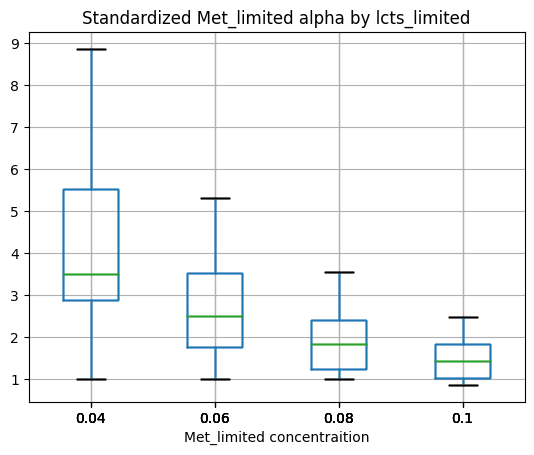

In [551]:
compare_limiting_Mets = compare_limiting_Mets()

In [309]:
# alpha_obj_df.query('`S0.ac_response` == "Essential or Phenotype"')[['S0.ac_div_opt_alpha','S0.gal_div_opt_alpha']]

,S0.ac_div_opt_alpha,S0.gal_div_opt_alpha
Gene_inhibition,,
gltA,1.005000,2.550000
tktA,17.818125,21.770625
dapF,25.723125,23.746875
dapB,7.267500,7.267500
acnB,1.075781,3.315000
pgk,1.446328,1.055859
mrcA,9.626250,11.538750
pyrE,19.794375,19.794375
dapD,5.482500,5.482500


In [589]:
obj = E0.reactions.BIOMASS_Ec_iML1515_core_75p37M
a=str(x).split(':')[0]

In [587]:
x['ID']

TypeError: 'Reaction' object is not subscriptable

In [ ]:
int(self.reactions[self.reactions.
                                            REACTION_NAMES == obj]['ID']

In [593]:
E0.reactions.REACTION_NAMES

AttributeError: DictList has no attribute or entry REACTION_NAMES

In [598]:
int(E.reactions[E.reactions.REACTION_NAMES==a]['ID'])

2669

In [595]:
E=c.model(E0)

In [ ]:
        obj = [str(x).split(':')[0]
               for x in reaction_list
               if x.objective_coefficient != 0][0]
        self.objective = int(self.reactions[self.reactions.
                                            REACTION_NAMES == obj]['ID'])
